# Single-Stage Model Evaluation Notebook

This notebook evaluates **single-stage object detection models** (e.g., YOLOv8, MegaDetector used directly) without a separate classification step.  
It measures performance across **cis** (in-domain) and **trans** (out-of-domain) validation and test splits.

## Main Steps

1. **Load Predictions & Ground Truth**
   - Reads COCO-style JSON files for predictions from a single-stage detector.
   - Loads the corresponding ground-truth annotation files for each split.

2. **Match Predictions to Ground Truth**
   - Uses IoU ≥ 0.3 to determine matches between predicted and ground-truth bounding boxes.
   - No secondary classification stage — detector outputs both bounding box and fine-grained class label in one step.

3. **Compute Evaluation Metrics**
   - Overall accuracy and weighted F1-score.
   - Per-class accuracies to understand class-specific performance.
   - Full classification reports (precision, recall, F1-score) for each split.

4. **Generate and Save Outputs**
   - **Classification reports** (CSV) per split.
   - **Comprehensive metrics** CSVs including overall and per-class accuracies.
   - **Confusion matrices**:
     - Raw confusion matrix CSVs.
     - Normalized PNG heatmaps for easy interpretation.
   - CSVs of unmatched predictions for error analysis.

## Purpose
This notebook provides a **baseline performance check** for detectors that directly output final class predictions, allowing comparison against the two-stage pipeline results.


In [3]:
from ultralytics import YOLO
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime
import yaml


WEIGHTS = {
    "y8_augmented_1"               : "../scripts/train/yolov8/yolov8_augmented/weights/best.pt",
    "y8_augmented_2"               : "../scripts/train/yolov8/yolov8_augmented4/weights/best.pt",
    "y8_augmented_light"               : "../scripts/train/yolov8/yolov8_augmented_lastrun/weights/best.pt",
    "y8_augmented_freezed_layers": "../scripts/train/yolov8/yolov8_augmented_freezed_layers/weights/best.pt",
    "y8_baseline"         : "../scripts/train/yolov8/y8_baseline_no_aug/weights/best.pt"
}

PROJECT_ROOT = Path("C:\caltech_camera_traps_project")
YAMLS = {
    PROJECT_ROOT / "configs" / "test" / "cis.yaml"   : "cis",
    PROJECT_ROOT / "configs" / "test" / "trans.yaml": "trans",
}

OUT_DIR   = Path("single_stage");  OUT_DIR.mkdir(exist_ok=True)
TRANS_YAML = [y for y, tag in YAMLS.items() if tag == "trans"][0]
IOU_FIXED = 0.50

In [ ]:
# ───────────────── hyperparameters ─────────────────────
CONF_GRID = np.linspace(0.05, 0.95, 19)     # 0.05 … 0.95


# ------------------------------------------------------------
# 1. Find best confidence thresholds using trans_val
# ------------------------------------------------------------
print("🔍 Finding best confidence thresholds on trans_val...")
TRANS_YAML = [y for y, tag in YAMLS.items() if tag == "trans"][0]

best_thresholds = {}
threshold_results = []

for model_name, weight_path in WEIGHTS.items():
    print(f"\n📊 Tuning {model_name}...")
    model = YOLO(weight_path)
    
    best_conf, best_f1 = None, -1
    model_results = []
    
    for c in CONF_GRID:
        m = model.val(data=TRANS_YAML, split="val",
                      conf=float(c), iou=IOU_FIXED,
                      verbose=False, plots=False)
        
        # Calculate F1 score
        precision = float(m.box.mp)
        recall = float(m.box.mr)
        f1 = 2 * precision * recall / (precision + recall + 1e-9)
        
        model_results.append({
            'model': model_name,
            'conf': c,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'mAP50': float(m.box.map50),
            'mAP50-95': float(m.box.map)
        })
        
        if f1 > best_f1:
            best_conf, best_f1 = c, f1
    
    best_thresholds[model_name] = best_conf
    threshold_results.extend(model_results)
    
    print(f"  ✓ Best conf = {best_conf:.2f} (F1={best_f1:.3f})")

# Save threshold tuning results
threshold_df = pd.DataFrame(threshold_results)
threshold_csv = OUT_DIR / "threshold_tuning_results.csv"
threshold_df.to_csv(threshold_csv, index=False)

# Save best thresholds for next step
thresholds_pkl = OUT_DIR / "best_thresholds.pkl"
with open(thresholds_pkl, 'wb') as f:
    pickle.dump(best_thresholds, f)

print(f"\n✔︎ Threshold tuning complete!")
print(f"✔︎ Results saved to {threshold_csv}")
print(f"✔︎ Best thresholds saved to {thresholds_pkl}")
print(f"\n📋 Best thresholds summary:")
for model, thresh in best_thresholds.items():
    print(f"  {model:30s}: {thresh:.2f}")

# Optional: Plot threshold tuning curves
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, model_name in enumerate(WEIGHTS.keys()):
    if i < len(axes):
        model_data = threshold_df[threshold_df['model'] == model_name]
        
        ax = axes[i]
        ax.plot(model_data['conf'], model_data['f1'], 'b-', label='F1', linewidth=2)
        ax.plot(model_data['conf'], model_data['precision'], 'r--', label='Precision', alpha=0.7)
        ax.plot(model_data['conf'], model_data['recall'], 'g--', label='Recall', alpha=0.7)
        
        # Mark best threshold
        best_conf = best_thresholds[model_name]
        best_row = model_data[model_data['conf'] == best_conf].iloc[0]
        ax.axvline(x=best_conf, color='orange', linestyle=':', alpha=0.8)
        ax.scatter([best_conf], [best_row['f1']], color='orange', s=100, zorder=5)
        
        ax.set_title(f'{model_name}\nBest: {best_conf:.2f}')
        ax.set_xlabel('Confidence Threshold')
        ax.set_ylabel('Score')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1)

# Remove empty subplots
for i in range(len(WEIGHTS), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig(OUT_DIR / "threshold_tuning_curves.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✔︎ Threshold tuning curves saved to {OUT_DIR / 'threshold_tuning_curves.png'}")

In [2]:
WEIGHTS_1 = {
    "y8_augmented_1"               : "../scripts/train/yolov8/yolov8_augmented/weights/best.pt",
    "y8_augmented_2"               : "../scripts/train/yolov8/yolov8_augmented4/weights/best.pt",
}


WEIGHTS_2 = {
    "y8_augmented_light"               : "../scripts/train/yolov8/yolov8_augmented_lastrun/weights/best.pt",
    "y8_augmented_freezed_layers": "../scripts/train/yolov8/yolov8_augmented_freezed_layers/weights/best.pt"
}

WEIGHTS_LAST = {
    "y8_baseline"         : "../scripts/train/yolov8/y8_baseline_no_aug/weights/best.pt",
}

rows = []

In [5]:
# ───────────────── helpers ─────────────────────
def get_class_names_from_yaml(yaml_path):
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)
    
    if 'names' in data:
        names = data['names']
        if isinstance(names, dict):
            # Convert {0: 'opossum', 1: 'raccoon', ...} to ['opossum', 'raccoon', ...]
            class_names = [names[i] for i in sorted(names.keys())]
            return class_names
        elif isinstance(names, list):
            return names
    
    return None


def save_cm(cm, names, tag):
    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # Handle division by zero (empty rows)
    cm_normalized = np.nan_to_num(cm_normalized)
    
    fig, ax = plt.subplots(figsize=(8, 6))  # Larger size for better readability
    
    # Create heatmap with normalized values
    sns.heatmap(cm_normalized, 
                xticklabels=names,  # Use class names instead of indices
                yticklabels=names,  # Use class names instead of indices
                cmap="Blues", 
                cbar=True,  # Show colorbar for normalized values
                ax=ax,
                annot=True,  # Show values in cells
                fmt='.2f',   # Format as 2 decimal places
                cbar_kws={'label': 'Normalized Count'})
    
    ax.set_title(f'Confusion Matrix - {tag}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    fig.tight_layout()
    fn = OUT_DIR / f"{tag}_cm.png"
    fig.savefig(fn, dpi=300, bbox_inches='tight')
    plt.close(fig)
    return fn

# Load best thresholds from previous step
thresholds_pkl = OUT_DIR / "best_thresholds.pkl"
with open(thresholds_pkl, 'rb') as f:
    best_thresholds = pickle.load(f)

print("📊 Loaded best thresholds:")
for model, thresh in best_thresholds.items():
    print(f"  {model:30s}: {thresh:.2f}")

# ------------------------------------------------------------
# 2. Evaluate all models with their best thresholds
# ------------------------------------------------------------
print(f"\n🚀 Evaluating all models with optimized thresholds...")

# Define evaluation splits
SPLITS = [
    (TRANS_YAML,                    "trans", "val"),
    (TRANS_YAML,                    "trans", "test"),  # trans_test
    *[(y, t, "val")  for y, t in YAMLS.items() if t == "cis"],   # cis_val
    *[(y, t, "test") for y, t in YAMLS.items() if t == "cis"],   # cis_test
]

model_objects = {}  # Cache loaded models

for model_name, weight_path in WEIGHTS_LAST.items():
    print(f"\n📈 Evaluating {model_name}...")
    
    # Load model once and cache it
    if model_name not in model_objects:
        model_objects[model_name] = YOLO(weight_path)
    model = model_objects[model_name]
    
    # Get the best threshold for this model
    best_conf = best_thresholds[model_name]
    
    # Evaluate on all splits
    for yaml_path, dom, split in SPLITS:
        tag = f"{model_name}_{dom}_{split}"
        
        # Run evaluation
        met = model.val(data=yaml_path, split=split,
                       conf=float(best_conf), iou=IOU_FIXED,
                       verbose=False, plots=True)
        
        # Save confusion matrix
        try:
            # Newer Ultralytics: metric.confusion_matrix.matrix
            cm = met.confusion_matrix.matrix
        except AttributeError:
            # Older builds: metric.box.confusion_matrix.matrix
            print("FAILED")
            cm = met.box.confusion_matrix.matrix
        
        try:
            # Get class names from the dataset YAML
            class_names = get_class_names_from_yaml(yaml_path)
            print(f"Class names from YAML: {class_names}")
            
            if cm is not None and cm.sum() > 0:
                cm_png = save_cm(cm, class_names, tag)  # Use YAML class names
            else:
                print(f"Empty confusion matrix for {tag}")
                cm_png = None
        except Exception as e:
            print(f"Error with confusion matrix: {e}")
            cm_png = None
        
        # Calculate metrics
        precision = float(met.box.mp)
        recall = float(met.box.mr)
        f1 = 2 * precision * recall / (precision + recall + 1e-9)
        
        # Store results
        row = {
            "model"      : model_name,
            "domain"     : dom,
            "split"      : split,
            "conf"       : round(best_conf, 2),
            "precision"  : precision,
            "recall"     : recall,
            "F1"         : f1,
            "mAP50"      : float(met.box.map50),
            "mAP50-95"   : float(met.box.map),
            "cm_png"     : cm_png.name,
            "eval_time"  : datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
        rows.append(row)
        
        print(f"  {tag:35s} P={precision:.3f}  R={recall:.3f}  F1={f1:.3f}")



📊 Loaded best thresholds:
  y8_augmented_1                : 0.30
  y8_augmented_2                : 0.10
  y8_augmented_light            : 0.25
  y8_augmented_freezed_layers   : 0.05
  y8_baseline                   : 0.05

🚀 Evaluating all models with optimized thresholds...

📈 Evaluating y8_baseline...
Ultralytics YOLOv8.0.238 🚀 Python-3.11.13 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)


c:\Users\cilek\anaconda3\envs\torch_env\Lib\site-packages\ultralytics\nn\tasks.py:589: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cp

Model summary (fused): 168 layers, 11131002 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning C:\caltech_camera_traps_project\data\yolo_images\trans_val\labels.cache... 1972 images, 57 backgrounds, 0 corrupt: 100%|██████████| 1972/1972 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [00:12<00:00,  9.67it/s]


                   all       1972       2047      0.428      0.357      0.386      0.292
Speed: 0.2ms preprocess, 4.1ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs\detect\val17
Class names from YAML: ['opossum', 'raccoon', 'squirrel', 'bobcat', 'skunk', 'dog', 'coyote', 'rabbit', 'bird', 'cat', 'badger', 'car', 'deer', 'rodent']


C:\Users\cilek\AppData\Local\Temp\ipykernel_9392\1190050859.py:20: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


  y8_baseline_trans_val               P=0.428  R=0.357  F1=0.390
Ultralytics YOLOv8.0.238 🚀 Python-3.11.13 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)


val: Scanning C:\caltech_camera_traps_project\data\yolo_images\trans_test\labels.cache... 18553 images, 1782 backgrounds, 0 corrupt: 100%|██████████| 18553/18553 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1160/1160 [02:06<00:00,  9.15it/s]


                   all      18553      17490      0.525      0.409      0.442      0.313
Speed: 0.2ms preprocess, 4.2ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs\detect\val18
Class names from YAML: ['opossum', 'raccoon', 'squirrel', 'bobcat', 'skunk', 'dog', 'coyote', 'rabbit', 'bird', 'cat', 'badger', 'car', 'deer', 'rodent']
  y8_baseline_trans_test              P=0.525  R=0.409  F1=0.460
Ultralytics YOLOv8.0.238 🚀 Python-3.11.13 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)


val: Scanning C:\caltech_camera_traps_project\data\yolo_images\cis_val\labels.cache... 1764 images, 79 backgrounds, 0 corrupt: 100%|██████████| 1764/1764 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:13<00:00,  8.19it/s]


                   all       1764       1783      0.823      0.681      0.774      0.548
Speed: 0.2ms preprocess, 4.2ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs\detect\val19
Class names from YAML: ['opossum', 'raccoon', 'squirrel', 'bobcat', 'skunk', 'dog', 'coyote', 'rabbit', 'bird', 'cat', 'badger', 'car', 'deer', 'rodent']


C:\Users\cilek\AppData\Local\Temp\ipykernel_9392\1190050859.py:20: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


  y8_baseline_cis_val                 P=0.823  R=0.681  F1=0.745
Ultralytics YOLOv8.0.238 🚀 Python-3.11.13 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)


val: Scanning C:\caltech_camera_traps_project\data\yolo_images\cis_test\labels.cache... 12141 images, 96 backgrounds, 0 corrupt: 100%|██████████| 12141/12141 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 759/759 [01:25<00:00,  8.85it/s]


                   all      12141      12569      0.819      0.592      0.679      0.461
Speed: 0.2ms preprocess, 4.1ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs\detect\val20
Class names from YAML: ['opossum', 'raccoon', 'squirrel', 'bobcat', 'skunk', 'dog', 'coyote', 'rabbit', 'bird', 'cat', 'badger', 'car', 'deer', 'rodent']
  y8_baseline_cis_test                P=0.819  R=0.592  F1=0.687


In [ ]:
WEIGHTS_LAST = {
    "megadetectorv6": "../scripts/train/megadetector_v6/megadetector_augmented_all_classes/weights/best.pt"
}


# ───────────────── hyperparameters ─────────────────────
CONF_GRID = np.linspace(0.05, 0.95, 19)     # 0.05 … 0.95


# ------------------------------------------------------------
# 1. Find best confidence thresholds using trans_val
# ------------------------------------------------------------
print("🔍 Finding best confidence thresholds on trans_val...")
TRANS_YAML = [y for y, tag in YAMLS.items() if tag == "trans"][0]

best_thresholds = {}
threshold_results = []

for model_name, weight_path in WEIGHTS_LAST.items():
    print(f"\n📊 Tuning {model_name}...")
    model = YOLO(weight_path)
    
    best_conf, best_f1 = None, -1
    model_results = []
    
    for c in CONF_GRID:
        m = model.val(data=TRANS_YAML, split="val",
                      conf=float(c), iou=IOU_FIXED,
                      verbose=False, plots=False)
        
        # Calculate F1 score
        precision = float(m.box.mp)
        recall = float(m.box.mr)
        f1 = 2 * precision * recall / (precision + recall + 1e-9)
        
        model_results.append({
            'model': model_name,
            'conf': c,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'mAP50': float(m.box.map50),
            'mAP50-95': float(m.box.map)
        })
        
        if f1 > best_f1:
            best_conf, best_f1 = c, f1
    
    best_thresholds[model_name] = best_conf
    threshold_results.extend(model_results)
    
    print(f"  ✓ Best conf = {best_conf:.2f} (F1={best_f1:.3f})")

# Save threshold tuning results
threshold_df = pd.DataFrame(threshold_results)
threshold_csv = OUT_DIR / "threshold_tuning_result_megadetector.csv"
threshold_df.to_csv(threshold_csv, index=False)

# Save best thresholds for next step
thresholds_pkl = OUT_DIR / "best_threshold_megadetector.pkl"
with open(thresholds_pkl, 'wb') as f:
    pickle.dump(best_thresholds, f)

print(f"\n✔︎ Threshold tuning complete!")
print(f"✔︎ Results saved to {threshold_csv}")
print(f"✔︎ Best thresholds saved to {thresholds_pkl}")
print(f"\n📋 Best thresholds summary:")
for model, thresh in best_thresholds.items():
    print(f"  {model:30s}: {thresh:.2f}")

# Optional: Plot threshold tuning curves
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, model_name in enumerate(WEIGHTS.keys()):
    if i < len(axes):
        model_data = threshold_df[threshold_df['model'] == model_name]
        
        ax = axes[i]
        ax.plot(model_data['conf'], model_data['f1'], 'b-', label='F1', linewidth=2)
        ax.plot(model_data['conf'], model_data['precision'], 'r--', label='Precision', alpha=0.7)
        ax.plot(model_data['conf'], model_data['recall'], 'g--', label='Recall', alpha=0.7)
        
        # Mark best threshold
        best_conf = best_thresholds[model_name]
        best_row = model_data[model_data['conf'] == best_conf].iloc[0]
        ax.axvline(x=best_conf, color='orange', linestyle=':', alpha=0.8)
        ax.scatter([best_conf], [best_row['f1']], color='orange', s=100, zorder=5)
        
        ax.set_title(f'{model_name}\nBest: {best_conf:.2f}')
        ax.set_xlabel('Confidence Threshold')
        ax.set_ylabel('Score')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1)

# Remove empty subplots
for i in range(len(WEIGHTS), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig(OUT_DIR / "threshold_tuning_curve_megadetector.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✔︎ Threshold tuning curves saved to {OUT_DIR / 'threshold_tuning_curve_megadetector.png'}")

In [5]:
# ───────────────── helpers ─────────────────────
def get_class_names_from_yaml(yaml_path):
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)
    
    if 'names' in data:
        names = data['names']
        if isinstance(names, dict):
            # Convert {0: 'opossum', 1: 'raccoon', ...} to ['opossum', 'raccoon', ...]
            class_names = [names[i] for i in sorted(names.keys())]
            return class_names
        elif isinstance(names, list):
            return names
    
    return None


def save_cm(cm, names, tag):
    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # Handle division by zero (empty rows)
    cm_normalized = np.nan_to_num(cm_normalized)
    
    fig, ax = plt.subplots(figsize=(8, 6))  # Larger size for better readability
    
    # Create heatmap with normalized values
    sns.heatmap(cm_normalized, 
                xticklabels=names,  # Use class names instead of indices
                yticklabels=names,  # Use class names instead of indices
                cmap="Blues", 
                cbar=True,  # Show colorbar for normalized values
                ax=ax,
                annot=True,  # Show values in cells
                fmt='.2f',   # Format as 2 decimal places
                cbar_kws={'label': 'Normalized Count'})
    
    ax.set_title(f'Confusion Matrix - {tag}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    fig.tight_layout()
    fn = OUT_DIR / f"{tag}_cm.png"
    fig.savefig(fn, dpi=300, bbox_inches='tight')
    plt.close(fig)
    return fn

# Load best thresholds from previous step
thresholds_pkl = OUT_DIR / "best_threshold_megadetector.pkl"
with open(thresholds_pkl, 'rb') as f:
    best_thresholds = pickle.load(f)

print("📊 Loaded best thresholds:")
for model, thresh in best_thresholds.items():
    print(f"  {model:30s}: {thresh:.2f}")

# ------------------------------------------------------------
# 2. Evaluate all models with their best thresholds
# ------------------------------------------------------------
print(f"\n🚀 Evaluating all models with optimized thresholds...")

# Define evaluation splits
SPLITS = [
    (TRANS_YAML,                    "trans", "val"),
    (TRANS_YAML,                    "trans", "test"),  # trans_test
    *[(y, t, "val")  for y, t in YAMLS.items() if t == "cis"],   # cis_val
    *[(y, t, "test") for y, t in YAMLS.items() if t == "cis"],   # cis_test
]

model_objects = {}  # Cache loaded models
rows = []

for model_name, weight_path in WEIGHTS_LAST.items():
    print(f"\n📈 Evaluating {model_name}...")
    
    # Load model once and cache it
    if model_name not in model_objects:
        model_objects[model_name] = YOLO(weight_path)
    model = model_objects[model_name]
    
    # Get the best threshold for this model
    best_conf = best_thresholds[model_name]
    
    # Evaluate on all splits
    for yaml_path, dom, split in SPLITS:
        tag = f"{model_name}_{dom}_{split}"
        
        # Run evaluation
        met = model.val(data=yaml_path, split=split,
                       conf=float(best_conf), iou=IOU_FIXED,
                       verbose=False, plots=True)
        
        # Save confusion matrix
        try:
            # Newer Ultralytics: metric.confusion_matrix.matrix
            cm = met.confusion_matrix.matrix
        except AttributeError:
            # Older builds: metric.box.confusion_matrix.matrix
            print("FAILED")
            cm = met.box.confusion_matrix.matrix
        
        try:
            # Get class names from the dataset YAML
            class_names = get_class_names_from_yaml(yaml_path)
            print(f"Class names from YAML: {class_names}")
            
            if cm is not None and cm.sum() > 0:
                cm_png = save_cm(cm, class_names, tag)  # Use YAML class names
            else:
                print(f"Empty confusion matrix for {tag}")
                cm_png = None
        except Exception as e:
            print(f"Error with confusion matrix: {e}")
            cm_png = None
        
        # Calculate metrics
        precision = float(met.box.mp)
        recall = float(met.box.mr)
        f1 = 2 * precision * recall / (precision + recall + 1e-9)
        
        # Store results
        row = {
            "model"      : model_name,
            "domain"     : dom,
            "split"      : split,
            "conf"       : round(best_conf, 2),
            "precision"  : precision,
            "recall"     : recall,
            "F1"         : f1,
            "mAP50"      : float(met.box.map50),
            "mAP50-95"   : float(met.box.map),
            "cm_png"     : cm_png.name,
            "eval_time"  : datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
        rows.append(row)
        
        print(f"  {tag:35s} P={precision:.3f}  R={recall:.3f}  F1={f1:.3f}")



📊 Loaded best thresholds:
  megadetectorv6                : 0.15

🚀 Evaluating all models with optimized thresholds...

📈 Evaluating megadetectorv6...
Ultralytics 8.3.163  Python-3.11.13 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
YOLOv9c summary (fused): 156 layers, 25,330,042 parameters, 0 gradients, 102.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 831.8112.8 MB/s, size: 83.6 KB)


val: Scanning C:\caltech_camera_traps_project\data\yolo_images\trans_val\labels.cache... 1972 images, 57 backgrounds, 0 corrupt: 100%|██████████| 1972/1972 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [00:32<00:00,  3.85it/s]


                   all       1972       2047      0.721      0.542      0.594      0.393
Speed: 0.2ms preprocess, 13.6ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs\detect\val40
Class names from YAML: ['opossum', 'raccoon', 'squirrel', 'bobcat', 'skunk', 'dog', 'coyote', 'rabbit', 'bird', 'cat', 'badger', 'car', 'deer', 'rodent']
  megadetectorv6_trans_val            P=0.721  R=0.542  F1=0.619
Ultralytics 8.3.163  Python-3.11.13 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
val: Fast image access  (ping: 0.10.1 ms, read: 220.4112.9 MB/s, size: 104.4 KB)


val: Scanning C:\caltech_camera_traps_project\data\yolo_images\trans_test\labels.cache... 18553 images, 1782 backgrounds, 0 corrupt: 100%|██████████| 18553/18553 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1160/1160 [05:19<00:00,  3.63it/s]


                   all      18553      17490      0.676      0.597      0.633      0.428
Speed: 0.2ms preprocess, 14.9ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs\detect\val41
Class names from YAML: ['opossum', 'raccoon', 'squirrel', 'bobcat', 'skunk', 'dog', 'coyote', 'rabbit', 'bird', 'cat', 'badger', 'car', 'deer', 'rodent']
  megadetectorv6_trans_test           P=0.676  R=0.597  F1=0.634
Ultralytics 8.3.163  Python-3.11.13 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
val: Fast image access  (ping: 0.10.0 ms, read: 235.976.3 MB/s, size: 144.5 KB)


val: Scanning C:\caltech_camera_traps_project\data\yolo_images\cis_val\labels.cache... 1764 images, 79 backgrounds, 0 corrupt: 100%|██████████| 1764/1764 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:31<00:00,  3.56it/s]


                   all       1764       1783      0.854      0.812      0.867      0.616
Speed: 0.2ms preprocess, 14.7ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs\detect\val42
Class names from YAML: ['opossum', 'raccoon', 'squirrel', 'bobcat', 'skunk', 'dog', 'coyote', 'rabbit', 'bird', 'cat', 'badger', 'car', 'deer', 'rodent']


C:\Users\cilek\AppData\Local\Temp\ipykernel_16496\2575106073.py:20: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


  megadetectorv6_cis_val              P=0.854  R=0.812  F1=0.833
Ultralytics 8.3.163  Python-3.11.13 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
val: Fast image access  (ping: 0.10.1 ms, read: 222.883.8 MB/s, size: 112.9 KB)


val: Scanning C:\caltech_camera_traps_project\data\yolo_images\cis_test\labels.cache... 12141 images, 96 backgrounds, 0 corrupt: 100%|██████████| 12141/12141 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 759/759 [03:35<00:00,  3.52it/s]


                   all      12141      12569      0.804      0.778      0.826      0.567
Speed: 0.2ms preprocess, 14.9ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs\detect\val43
Class names from YAML: ['opossum', 'raccoon', 'squirrel', 'bobcat', 'skunk', 'dog', 'coyote', 'rabbit', 'bird', 'cat', 'badger', 'car', 'deer', 'rodent']


C:\Users\cilek\AppData\Local\Temp\ipykernel_16496\2575106073.py:20: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


  megadetectorv6_cis_test             P=0.804  R=0.778  F1=0.791


✔︎   summary_metrics.csv updated with 4 new rows

✔︎ Main metrics written to C:\caltech_camera_traps_project\eval\single_stage\summary_metrics.csv
✔︎ Detailed analysis written to C:\caltech_camera_traps_project\eval\single_stage\detailed_analysis.csv

📊 EVALUATION SUMMARY:

🎯 Performance by Domain:
                 F1                       mAP50                     
               mean    std    max    min   mean    std    max    min
domain split                                                        
cis    test   0.731  0.038  0.791  0.687  0.745  0.050  0.826  0.679
       val    0.793  0.032  0.833  0.745  0.817  0.034  0.867  0.774
trans  test   0.493  0.075  0.634  0.427  0.489  0.078  0.633  0.422
       val    0.451  0.091  0.619  0.376  0.439  0.083  0.594  0.384

🏆 Best Models per Split:
  trans_val : megadetectorv6                 (F1=0.619)
  trans_test: megadetectorv6                 (F1=0.634)
  cis_val : megadetectorv6                 (F1=0.833)
  cis_test: megadetectorv

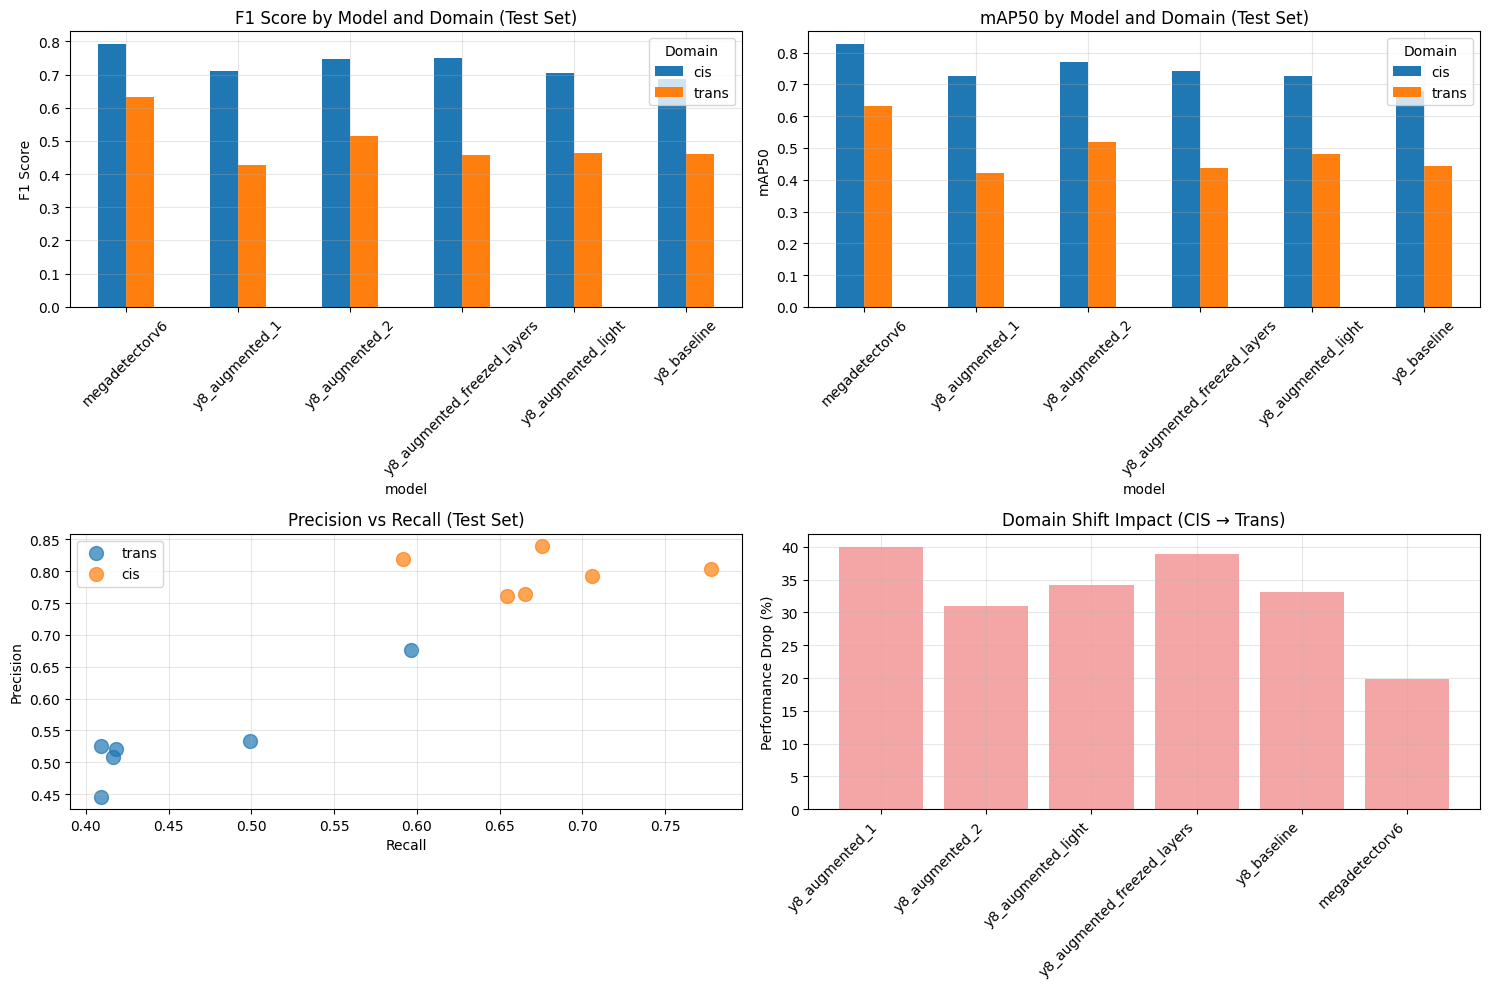

✔︎ Evaluation summary plot saved to single_stage\evaluation_summary.png

🎉 Evaluation complete! Check single_stage for all results.

📋 Final Results DataFrame:


,model,domain,split,conf,precision,recall,F1,mAP50,mAP50-95,cm_png,eval_time
0,y8_augmented_1,trans,val,0.30,0.423952,0.337519,0.375830,0.383935,0.285956,y8_augmented_1_trans_val_cm.png,2025-07-22 14:32:03
1,y8_augmented_1,trans,test,0.30,0.446106,0.408892,0.426689,0.421551,0.300139,y8_augmented_1_trans_test_cm.png,2025-07-22 14:35:39
2,y8_augmented_1,cis,val,0.30,0.816865,0.767529,0.791429,0.815890,0.587955,y8_augmented_1_cis_val_cm.png,2025-07-22 14:37:23
3,y8_augmented_1,cis,test,0.30,0.763777,0.665611,0.711323,0.727567,0.506389,y8_augmented_1_cis_test_cm.png,2025-07-22 14:40:14
4,y8_augmented_2,trans,val,0.10,0.550328,0.434211,0.485422,0.468799,0.345572,y8_augmented_2_trans_val_cm.png,2025-07-22 14:42:39
5,y8_augmented_2,trans,test,0.10,0.533595,0.499041,0.515740,0.517526,0.364773,y8_augmented_2_trans_test_cm.png,2025-07-22 14:45:59
6,y8_augmented_2,cis,val,0.10,0.864194,0.778490,0.819106,0.840897,0.613293,y8_augmented_2_cis_val_cm.png,2025-07-22 14:47:00
7,y8_augmented_2,cis,test,0.10,0.792613,0.705997,0.746802,0.771559,0.541525,y8_augmented_2_cis_test_cm.png,2025-07-22 14:51:41
8,y8_augmented_light,trans,val,0.25,0.440781,0.390523,0.414133,0.418100,0.315923,y8_augmented_light_trans_val_cm.png,2025-07-22 14:55:00
9,y8_augmented_light,trans,test,0.25,0.520487,0.418104,0.463711,0.481739,0.337196,y8_augmented_light_trans_test_cm.png,2025-07-22 15:00:03


In [6]:
# ------------------------------------------------------------
# 3. Save and analyze results
# ------------------------------------------------------------



# Save main summary
csv_path = OUT_DIR / "summary_metrics.csv"

df_new = pd.DataFrame(rows)

df_old = pd.read_csv(csv_path)
merge_keys = ["model", "domain", "split"]

df_combined = (
    pd.concat([df_old, df_new], ignore_index=True)
      # sort so the newest rows are last, then drop earlier dups
      .sort_values("eval_time")
      .drop_duplicates(subset=merge_keys, keep="last")
      .reset_index(drop=True)
)

df_combined.to_csv(csv_path, index=False)
print(f"✔︎   summary_metrics.csv updated with {len(df_new)} new rows")

df = df_combined

# Save additional detailed analysis
detailed_path = OUT_DIR / "detailed_analysis.csv"
df_detailed = df.copy()

# Add performance comparisons
df_detailed['domain_shift'] = df_detailed.apply(
    lambda row: 'in_domain' if row['domain'] == 'cis' else 'out_domain', axis=1
)

# Calculate relative performance (compared to best model per split)
for split_combo in df_detailed[['domain', 'split']].drop_duplicates().values:
    dom, spl = split_combo
    mask = (df_detailed['domain'] == dom) & (df_detailed['split'] == spl)
    best_f1 = df_detailed[mask]['F1'].max()
    df_detailed.loc[mask, 'relative_f1'] = df_detailed.loc[mask, 'F1'] / best_f1

df_detailed.to_csv(detailed_path, index=False)

print(f"\n✔︎ Main metrics written to {csv_path.resolve()}")
print(f"✔︎ Detailed analysis written to {detailed_path.resolve()}")

# Display summary statistics
print(f"\n📊 EVALUATION SUMMARY:")
print(f"{'='*60}")

# Summary by domain
print("\n🎯 Performance by Domain:")
domain_summary = df.groupby(['domain', 'split']).agg({
    'F1': ['mean', 'std', 'max', 'min'],
    'mAP50': ['mean', 'std', 'max', 'min']
}).round(3)
print(domain_summary)

# Best performing models per split
print(f"\n🏆 Best Models per Split:")
for split_combo in df[['domain', 'split']].drop_duplicates().values:
    dom, spl = split_combo
    mask = (df['domain'] == dom) & (df['split'] == spl)
    best_row = df[mask].loc[df[mask]['F1'].idxmax()]
    print(f"  {dom}_{spl:4s}: {best_row['model']:30s} (F1={best_row['F1']:.3f})")

# Domain shift analysis
print(f"\n🔄 Domain Shift Analysis:")
cis_test = df[(df['domain'] == 'cis') & (df['split'] == 'test')]
trans_test = df[(df['domain'] == 'trans') & (df['split'] == 'test')]

for model in df['model'].unique():
    cis_f1 = cis_test[cis_test['model'] == model]['F1'].iloc[0]
    trans_f1 = trans_test[trans_test['model'] == model]['F1'].iloc[0]
    drop = ((cis_f1 - trans_f1) / cis_f1) * 100
    print(f"  {model:30s}: {drop:+5.1f}% drop (cis: {cis_f1:.3f} → trans: {trans_f1:.3f})")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: F1 scores by model and domain
ax1 = axes[0, 0]
test_data = df[df['split'] == 'test']
pivot_f1 = test_data.pivot(index='model', columns='domain', values='F1')
pivot_f1.plot(kind='bar', ax=ax1, rot=45)
ax1.set_title('F1 Score by Model and Domain (Test Set)')
ax1.set_ylabel('F1 Score')
ax1.legend(title='Domain')
ax1.grid(True, alpha=0.3)

# Plot 2: mAP50 scores
ax2 = axes[0, 1]
pivot_map = test_data.pivot(index='model', columns='domain', values='mAP50')
pivot_map.plot(kind='bar', ax=ax2, rot=45)
ax2.set_title('mAP50 by Model and Domain (Test Set)')
ax2.set_ylabel('mAP50')
ax2.legend(title='Domain')
ax2.grid(True, alpha=0.3)

# Plot 3: Precision vs Recall
ax3 = axes[1, 0]
for domain in df['domain'].unique():
    domain_data = test_data[test_data['domain'] == domain]
    ax3.scatter(domain_data['recall'], domain_data['precision'], 
               label=domain, alpha=0.7, s=100)
ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')
ax3.set_title('Precision vs Recall (Test Set)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Domain shift impact
ax4 = axes[1, 1]
models = []
domain_drops = []
for model in df['model'].unique():
    try:
        cis_f1 = cis_test[cis_test['model'] == model]['F1'].iloc[0]
        trans_f1 = trans_test[trans_test['model'] == model]['F1'].iloc[0]
        drop = ((cis_f1 - trans_f1) / cis_f1) * 100
        models.append(model)
        domain_drops.append(drop)
    except:
        pass

ax4.bar(range(len(models)), domain_drops, color='lightcoral', alpha=0.7)
ax4.set_xticks(range(len(models)))
ax4.set_xticklabels(models, rotation=45, ha='right')
ax4.set_ylabel('Performance Drop (%)')
ax4.set_title('Domain Shift Impact (CIS → Trans)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUT_DIR / "evaluation_summary.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✔︎ Evaluation summary plot saved to {OUT_DIR / 'evaluation_summary.png'}")
print(f"\n🎉 Evaluation complete! Check {OUT_DIR} for all results.")

# Display final dataframe
print(f"\n📋 Final Results DataFrame:")
df

In [8]:


out_dir = Path("../models")
out_dir.mkdir(parents=True, exist_ok=True)
ckpt_path = Path("../scripts/train/yolov8/yolov8_augmented4/weights/best.pt")


# 1) Load the trained checkpoint
model = YOLO(str(ckpt_path))
onnx_name = out_dir / "yolov8_augmented.onnx"

# 2) Pick one or more export targets
model.export(format="onnx", imgsz=640, simplify=True, dynamic=True, nms=True)
(ckpt_path.parent / "best.onnx").rename(onnx_name)

c:\Users\cilek\anaconda3\envs\torch_env\Lib\site-packages\ultralytics\nn\tasks.py:589: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cp

Ultralytics YOLOv8.0.238 🚀 Python-3.11.13 torch-2.5.1 CPU (AMD Ryzen 9 7940HS w/ Radeon 780M Graphics)
Model summary (fused): 168 layers, 11131002 parameters, 0 gradients, 28.5 GFLOPs

PyTorch: starting from '..\scripts\train\yolov8\yolov8_augmented4\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 18, 8400) (128.0 MB)

ONNX: starting export with onnx 1.18.0 opset 19...
ONNX: simplifying with onnxsim 0.4.36...
ONNX: export success ✅ 1.6s, saved as '..\scripts\train\yolov8\yolov8_augmented4\weights\best.onnx' (42.5 MB)

Export complete (3.5s)
Results saved to C:\caltech_camera_traps_project\scripts\train\yolov8\yolov8_augmented4\weights
Predict:         yolo predict task=detect model=..\scripts\train\yolov8\yolov8_augmented4\weights\best.onnx imgsz=640  
Validate:        yolo val task=detect model=..\scripts\train\yolov8\yolov8_augmented4\weights\best.onnx imgsz=640 data=C:\caltech_camera_traps_project\configs\model\yolo_balanced.yaml  
Visualize:       ht

WindowsPath('../models/yolov8_augmented.onnx')

In [1]:
from pathlib import Path
from ultralytics import YOLO   # same library works for MD-v6 weights

ckpt_path = Path("../scripts/train/megadetector_v6/megadetector_augmented_all_classes/weights/best.pt")   # adjust if needed
out_dir   = Path("../models")
out_dir.mkdir(parents=True, exist_ok=True)

model = YOLO(str(ckpt_path))
onnx_name = out_dir / "megadetectorv6_allClasses.onnx"
model.export(format="onnx", imgsz=640, simplify=True, dynamic=True, nms=True)
(ckpt_path.parent / "best.onnx").rename(onnx_name)

print(f"✅ exported → {onnx_name.resolve()}")


Ultralytics 8.3.163  Python-3.11.13 torch-2.5.1+cu121 CPU (AMD Ryzen 9 7940HS w/ Radeon 780M Graphics)
YOLOv9c summary (fused): 156 layers, 25,330,042 parameters, 0 gradients, 102.4 GFLOPs

PyTorch: starting from '..\scripts\train\megadetector_v6\megadetector_augmented_all_classes\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 300, 6) (49.2 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.61...
ONNX: export success  11.6s, saved as '..\scripts\train\megadetector_v6\megadetector_augmented_all_classes\weights\best.onnx' (96.8 MB)

Export complete (14.9s)
Results saved to C:\caltech_camera_traps_project\scripts\train\megadetector_v6\megadetector_augmented_all_classes\weights
Predict:         yolo predict task=detect model=..\scripts\train\megadetector_v6\megadetector_augmented_all_classes\weights\best.onnx imgsz=640  
Validate:        yolo val task=detect model=..\scripts\train\megadetector_v6\megadetector_augmented_

In [ ]:
from pathlib import Path

out_dir = Path("../models")
out_dir.mkdir(parents=True, exist_ok=True)

thresholds_txt = out_dir / "thresholds.txt"
thresholds_txt.write_text(
    "megadetector_v6_all_classes : 0.15\n"
    "y8_augmented_2  : 0.10\n"
)

print(f" thresholds saved → {thresholds_txt.resolve()}")


 thresholds saved → C:\caltech_camera_traps_project\models\thresholds.txt


In [2]:
# ──────────────────────────────────────────────────────────────
# Benchmark one exported ONNX model on the test set and log time
# ──────────────────────────────────────────────────────────────
from ultralytics import YOLO
from pathlib import Path
import pandas as pd
import time
out_dir = Path("../models")
# ── 1. CONFIG ────────────────────────────────────────────────
MODEL_NAME  = "yolov8_augmented"           # ← change to "megadetector_v6"
CONF_TH     = 0.10                       # ← change to 0.15 for MD-v6
ONNX_PATH   = out_dir / f"{MODEL_NAME}.onnx"
TEST_DIR    = Path("../data/yolo_images/val/images")   # folder of *.jpg / *.png

LOG_CSV     = Path("../models/inference_times.csv")
LOG_CSV.parent.mkdir(parents=True, exist_ok=True)

# ── 2. RUN & TIME  ───────────────────────────────────────────
model = YOLO(ONNX_PATH, task="detect")

t0 = time.perf_counter()
results = model.predict(source=str(TEST_DIR),
                        imgsz=640,
                        conf=CONF_TH,
                        save=False,
                        verbose=False)
t1 = time.perf_counter()

num_imgs     = len(results)
total_secs   = t1 - t0
avg_secs     = total_secs / num_imgs
fps          = 1 / avg_secs

print(f"\n{MODEL_NAME}: {num_imgs} images  |  {total_secs:6.2f} s total  "
      f"→  {avg_secs*1000:5.1f} ms/img  ({fps:5.1f} FPS)")

# ── 3. LOG TO CSV  ───────────────────────────────────────────
row = {
    "model"        : MODEL_NAME,
    "images"       : num_imgs,
    "conf_thresh"  : CONF_TH,
    "total_sec"    : round(total_secs, 3),
    "sec_per_img"  : round(avg_secs, 4),
    "fps"          : round(fps, 2),
}

if LOG_CSV.exists():
    df_log = pd.read_csv(LOG_CSV)
    # drop any previous entry for this model so the latest timing wins
    df_log = df_log[df_log["model"] != MODEL_NAME]
    df_log = pd.concat([df_log, pd.DataFrame([row])], ignore_index=True)
else:
    df_log = pd.DataFrame([row])

df_log.to_csv(LOG_CSV, index=False)
print(f"✅ timing appended → {LOG_CSV.resolve()}")


# 3. Peek at the first few predictions -------------------------------------
print(f"\nFound {len(results)} images in {TEST_DIR}")
for i, r in enumerate(results[:3]):        # just display first 3
    print(f"\n🖼️  Image {i+1}: {Path(r.path).name}")
    for cls, conf, xyxy in zip(r.boxes.cls, r.boxes.conf, r.boxes.xyxy):
        label = r.names[int(cls)]
        x1, y1, x2, y2 = map(int, xyxy)
        print(f"   • {label:12s} {conf:5.2f}   box=({x1},{y1})–({x2},{y2})")

Loading ..\models\yolov8_augmented.onnx for ONNX Runtime inference...

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs


yolov8_augmented: 3736 images  |   86.53 s total  →   23.2 ms/img  ( 43.2 FPS)
✅ timing appended → C:\caltech_camera_traps_project\models\inference_times.csv

Found 3736 images in ..\data\yolo_images\val\images

🖼️  Image 1: 5858bfa6-23d2-11e8-a6a3-ec086b02610b.jpg
   • deer          0.87   box=(417,0)–(481,425)
   • deer          0.15   box=(614,10)–(674,296)

🖼️  Image 2: 5858bfe7-

In [ ]:
# ──────────────────────────────────────────────────────────────
# Benchmark one exported ONNX model on the test set and log time
# ──────────────────────────────────────────────────────────────
from ultralytics import YOLO
from pathlib import Path
import pandas as pd
import time
out_dir = Path("../models")
# ── 1. CONFIG ────────────────────────────────────────────────
MODEL_NAME  = "megadetectorv6_allClasses"           # ← change to "megadetector_v6"
CONF_TH     = 0.15                       # ← change to 0.15 for MD-v6
ONNX_PATH   = out_dir / f"{MODEL_NAME}.onnx"
TEST_DIR    = Path("../data/yolo_images/val/images")   # folder of *.jpg / *.png

LOG_CSV     = Path("../models/inference_times.csv")
LOG_CSV.parent.mkdir(parents=True, exist_ok=True)

# ── 2. RUN & TIME  ───────────────────────────────────────────
model = YOLO(ONNX_PATH, task="detect")

t0 = time.perf_counter()
results = model.predict(source=str(TEST_DIR),
                        imgsz=640,
                        conf=CONF_TH,
                        save=False,
                        verbose=False)
t1 = time.perf_counter()

num_imgs     = len(results)
total_secs   = t1 - t0
avg_secs     = total_secs / num_imgs
fps          = 1 / avg_secs

print(f"\n{MODEL_NAME}: {num_imgs} images  |  {total_secs:6.2f} s total  "
      f"→  {avg_secs*1000:5.1f} ms/img  ({fps:5.1f} FPS)")

# ── 3. LOG TO CSV  ───────────────────────────────────────────
row = {
    "model"        : MODEL_NAME,
    "images"       : num_imgs,
    "conf_thresh"  : CONF_TH,
    "total_sec"    : round(total_secs, 3),
    "sec_per_img"  : round(avg_secs, 4),
    "fps"          : round(fps, 2),
}

if LOG_CSV.exists():
    df_log = pd.read_csv(LOG_CSV)
    # drop any previous entry for this model so the latest timing wins
    df_log = df_log[df_log["model"] != MODEL_NAME]
    df_log = pd.concat([df_log, pd.DataFrame([row])], ignore_index=True)
else:
    df_log = pd.DataFrame([row])

df_log.to_csv(LOG_CSV, index=False)
print(f"✅ timing appended → {LOG_CSV.resolve()}")


# 3. Peek at the first few predictions -------------------------------------
print(f"\nFound {len(results)} images in {TEST_DIR}")
for i, r in enumerate(results[:3]):        # just display first 3
    print(f"\n🖼️  Image {i+1}: {Path(r.path).name}")
    for cls, conf, xyxy in zip(r.boxes.cls, r.boxes.conf, r.boxes.xyxy):
        label = r.names[int(cls)]
        x1, y1, x2, y2 = map(int, xyxy)
        print(f"   • {label:12s} {conf:5.2f}   box=({x1},{y1})–({x2},{y2})")

Loading ..\models\megadetectorv6_allClasses.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider
WARNING 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs


megadetectorv6_allClasses: 3736 images  |  232.45 s total  →   62.2 ms/img  ( 16.1 FPS)
✅ timing appended → C:\caltech_camera_traps_project\models\inference_times.csv

Found 3736 images in ..\data\yolo_images\val\images

🖼️  Image 1: 5858bfa6-23d2-11e8-a6a3-ec086b02610b.jpg
   • bobcat        0.79   box=(446,267)–(531,356)

🖼️  Image 2: 